## Integration of a N-body system
In this part of the homework a 9 bodies system is simulated using the 4-th order Runge-Kutta.
The system contains a central mass with mass close to the Sun ($M=2\cdot10^{30}$ $kg$) and 8 smaller masses with $m=10^{-4}M$ distributed from $2$ to $16$ a.u. and initial speed chosen to follow a circular orbit around the central mass.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.integrate import solve_ivp


In [2]:
N = 8
M_sol = 2e30  #Solar mass
G = 6.6743e-11  #G in m^3 s^-2 kg^-1
au = 1.495978707e11 #Au in m
yr = 365.2422*24*3600 #Year in s
# G is now converted in AU^3 yr^-2 Msol^-1
G = G*au**-3*yr**2*M_sol
q = 1e-3  #softening factor
M = 1
t0, tf = 0, 2e4


The initial velocity for a circular motion with radius r has been calculated as $v = \sqrt{\frac{GM}{r}}$

In [3]:
#Velocity of a circular orbit give the radius
v_circ = lambda r, GM:  (GM/r)**0.5


For the integration has been used the reltive form of the equation of motion centered on the principal mass using the Encke-Bettin formulation to improve numerical stability: $$ \mathbf{\ddot r_i}=-G\frac{M+m_i}{r^3_i}\mathbf{r}_i - \Sigma_{j\neq i}\frac{Gm_j}{\tilde r_{ij}^3}(\mathbf{r_i}+f_{ij}\mathbf{r_j}) $$
$$ q_{ij}=\frac{(\mathbf{r_i}-2\mathbf{r_j})\mathbf{r_i}}{r_j^2}$$
$$ f_{ij}=\frac{3q_{ij}+3q_{ij}^2+q_{ij}^3}{1+(1+q_{ij})^{1.5}} $$
To avoid the simulation collapsing in case of close encounters, Pakter and Levin used a smoothed of form of the potential:
\begin{cases}
V(r)= -\frac{(2d^3-2dr^2+r^3)Gm^2}{d^4} \quad r\leq d \\
V(r)= -\frac{Gm^2}{r}\quad r>d
\end{cases}
with $d=10^{-3}$ a.u. 
Because the scipy integrator cannot switch the form of the potential based on the distance, following the rebound documentation the following force was used $$ \mathbf F(r)=\frac{G m^2}{(r_{ij}^2+q^2)^{1.5}}\mathbf{r}_{ij}$$ that goes to zero for $r_{ij} \to 0$. Because the smaller masses are the most likely to undergo close encounters, this correction was done only for the distance between them ($\tilde r_{ij}$ in the equation above) with $q=10^{-3}$ a.u.

In [4]:
def N_body(t,y,G,M,m):
  
  r_ = lambda y,i : y[[4*i, 4*i+1]]
  v_i = lambda y,i : y[[4*i+2, 4*i+3]]
  r_ij = lambda y,i,j,q: (np.linalg.norm(r_(y,i)-r_(y,j))**2+q**2)**0.5
  g = []
  
  for i in range(N):
    r_i = r_(y,i)
    g_i = -G*(M+m[i])*r_i/np.linalg.norm(r_i)**3
    for j in range(N):
      if i==j:
        continue
      else:
        #Perturbation part of the force
        #Encke-Bettin formulation 
        r_j = r_(y,j)
        q_ij = np.dot(r_i-2*r_j, r_i)/np.dot(r_j,r_j)
        f_ij = (3*q_ij + 3*q_ij**2 +q_ij**3)/(1+(1+q_ij)**1.5)
        
        p_ij = -G*m[j]*(r_i+f_ij*r_j)/r_ij(y,i,j,q)**3
        g_i = g_i + p_ij 
  
    g.append(g_i)

  dy = [[v_i(y,i), g[i]] for i in range(N)]
  return np.array(dy).flatten()


In [5]:

m = 1e-4*np.ones(shape=N)
y0 = [[r,0,0,v_circ(r, G*M)] for r in np.linspace(2, 16, N)]
y0= np.array(y0).flatten()

Y1 = solve_ivp(N_body, t_span=(t0,tf), y0=y0, args=(G,M,m), rtol=1e-10, dense_output=True)


In [23]:
T = np.linspace(t0,tf,int(1e5))
y = Y1.sol(T)
R = np.array([y[4*i : 4*i+2] for i in range(N)])
V = np.array([y[4*i+2 : 4*i+4] for i in range(N)])


r = np.array([np.linalg.norm(r_i, axis=0) for r_i in R])


K = 0.5*np.sum([m[i]*np.linalg.norm(V[i], axis=0)**2 for i in range(N)], axis=0)

#Potential energy between the masses
U_ij = np.sum([-G*m[i]*m[j]/np.linalg.norm(R[i]-R[j], axis=0) for i in range(N) for j in range(i)], axis=0)

#Potential energy between a mass and the central one
U_central = np.sum([-G*M*m[i]/r[i] for i in range(N)], axis=0)
E = K+U_central+U_ij

L = np.sum([m_i*np.cross(r_i, v_i, axis=0) for m_i, r_i, v_i in zip(m,R,V)], axis=0)




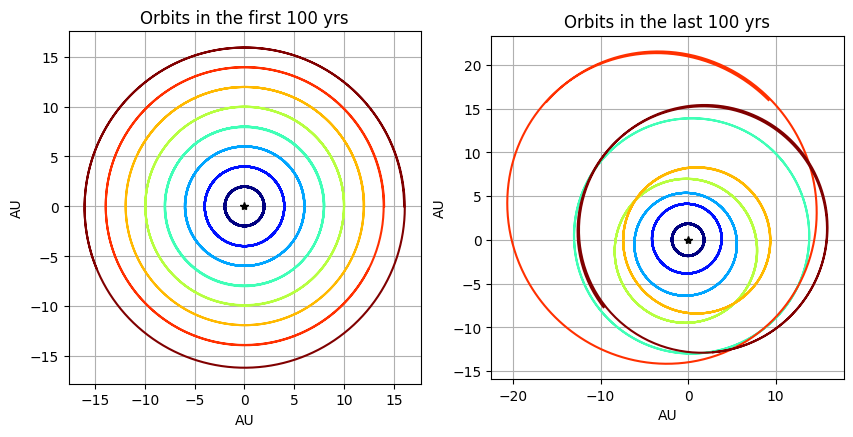

In [36]:
colors = cm.jet(np.linspace(0,1,N))

fig, AX = plt.subplots(1,2, figsize=(10,5))
AX[0].set_aspect('equal')
AX[0].grid()
AX[0].set_xlabel('AU')
AX[0].set_ylabel('AU')
AX[0].plot(0,0,'k*')
AX[1].set_aspect('equal')
AX[1].grid()
AX[1].set_xlabel('AU')
AX[1].set_ylabel('AU')
AX[1].plot(0,0,'k*')
AX[0].set_title('Orbits in the first 100 yrs')
AX[1].set_title('Orbits in the last 100 yrs')


for R_i,c in zip(R,colors):  
  AX[0].plot(R_i[0, :500], R_i[1, :500], color=c)

for R_i,c in zip(R,colors):  
  AX[1].plot(R_i[0, -500:], R_i[1, -500:], color=c)


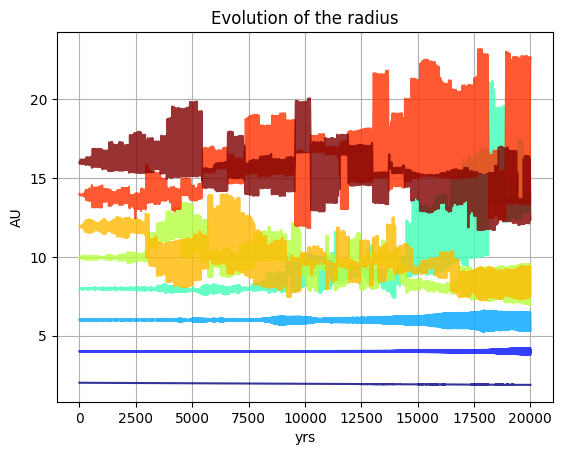

In [40]:
for r_i, c in zip(r, colors):
  plt.plot(T, r_i, alpha =0.8, color=c)
plt.grid()
plt.title('Evolution of the radius')
plt.xlabel('yrs')
plt.ylabel('AU')
plt.show()


Compared with results from the paper, the evolution of the system shows several migrations. The instability of the system starts earlier and the final order of the planets is different. Also from the plot in the paper it appeard that the planets orbits are never intersecting (i.e., the distances are overimposed only in some points and not for long periods of time, as it happens in my simulation). This could happen because the potential used is different and/or the integrator is different, even if the same relative tolerance ($rtol=10^{-10}$) is used.

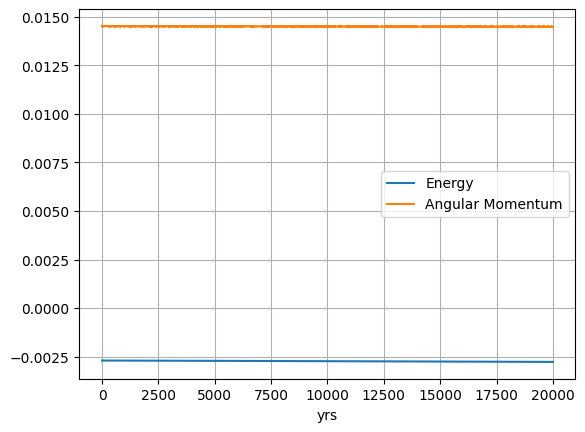

The relative error on the energy is 2.683530576332771%
The relative error on the angular momentum is -0.276056356559895%


In [42]:
plt.plot(T, E, label='Energy')
plt.plot(T, L, label='Angular Momentum')
plt.xlabel('yrs')
plt.grid()
plt.legend()
plt.show()

E_err = E[-1]/E[0]-1
L_err = L[-1]/L[0]-1

print(f'The relative error on the energy is {100*E_err}%')
print(f'The relative error on the angular momentum is {100*L_err}%')


The energy and the angular momentum are nearly constant during the evolution (zooming in a lot some small spikes can be seen, corresponding to close encounters), and the relative error from beginning to end is pretty small.  